In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [70]:
sim = EventSimulator(config)
num_evts = 100
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)


In [89]:
p = next(pgen)
print(p)
#good_1 = [7.78580357e-03, 2.05914266e-03, 5.69142329e-01, 1.44299609e+00, 4.21022635e+00, 1.98290584e+00]

(array([-3.71412809e-03, -1.82512553e-02,  4.87939809e-01,  7.42209054e+00,
        3.34770870e+00,  2.85447579e+00]), array([-0.00569367, -0.02797873, -0.9995923 ]))


In [90]:
evtRandom, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
pyevtRandom = sim.convert_event(evtRandom)
Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

In [91]:
Random_xy = Random_xyzs[:, 0:2]
Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
#The center of curvature of the track, in mm.
Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy), rotate_pads=True, drop_beampads=True)
Random_uvw_values = Random_uvw.values

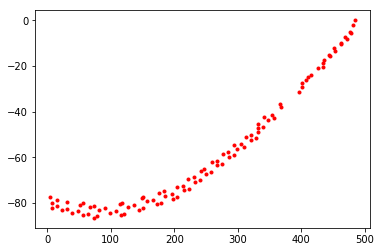

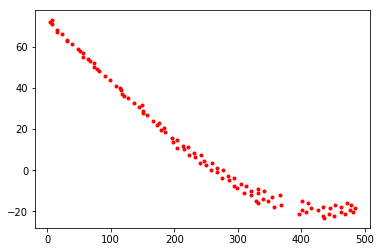

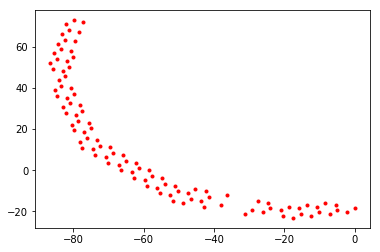

In [92]:
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 5], 'r.')
plt.show()
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 6], 'r.')
plt.show()
plt.plot(Random_uvw_values[:, 5], Random_uvw_values[:, 6], 'r.')



In [93]:
uvw_sorted = Random_uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, Random_cu, Random_cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000

In [94]:
exp_hits = np.zeros(10240)
for a, p in Random_uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
print(exp_hits)

[0. 0. 0. ... 0. 0. 0.]


In [95]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)

In [96]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,eps)

In [105]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, recombination=0.3, maxiter=10000, popsize=15, mutation=(0.5, 1.0))

   1-0.117559-0.051873 0.152017 4.704758-0.889028-3.042709 448.438316
   2-0.071292-0.008835 0.930859 2.972531 1.123677 5.900830 221.431130
   3-0.017500-0.031346 0.297215 3.614128 5.384809 1.215552 143.996192
   4-0.001161 0.001320 0.808640 1.155630 3.785740 1.270290 120.150956
   5-0.001161 0.001320 0.900879 1.155630-0.624148 1.270290 118.281599
   6-0.001161 0.001320 0.900879 1.155630-0.624148 1.270290 118.281599
   7-0.001161 0.001320 0.900879 1.155630-0.624148 1.270290 118.281599
   8-0.001161 0.001320 0.808640 2.360803 3.067161 1.270290 117.657741
   9 0.008286 0.009467 0.082481 3.015412-0.818146 0.038572 106.768573
  10-0.009992-0.010031 0.423577 3.763488 0.565196-2.782958 46.122135
  11-0.009992-0.010031 0.423577 3.763488 0.565196-2.782958 46.122135
  12-0.009992-0.010031 0.423577 3.763488 0.565196-2.782958 46.122135
  13-0.009992-0.010031 0.423577 3.763488 0.565196-2.782958 46.122135
  14-0.009992-0.010031 0.423577 3.763488 0.565196-2.782958 46.122135
  15-0.009992-0.010031 0.

 120 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 121 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 122 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 123 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 124 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 125 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 126 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 127 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 128 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 129 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 130 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 131 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 132 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 133 0.001179-0.001465 0.508822 4.886627 0.564118-2.873495 21.700240
 134 0.001179-0.001465 0.508822 4.

 239 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 240 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 241 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 242 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 243 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 244 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 245 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 246 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 247 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 248 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 249 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 250 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 251 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 252 0.001155-0.001375 0.508061 4.993219 0.571083-2.877227 21.433315
 253 0.001155-0.001375 0.508061 4.

In [98]:
results.fun

21.405669512269487

In [99]:
dfe = results.x
print(dfe)

[ 1.04572312e-03 -1.79116227e-03  5.04883626e-01  4.99902602e+00
  5.56104406e-01 -2.87485147e+00]


In [100]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


In [101]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

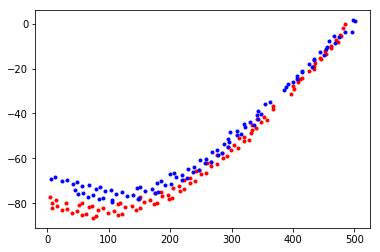

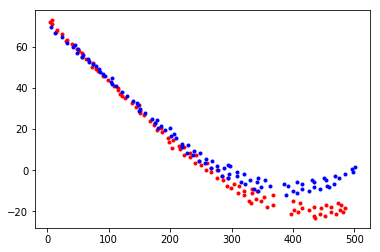

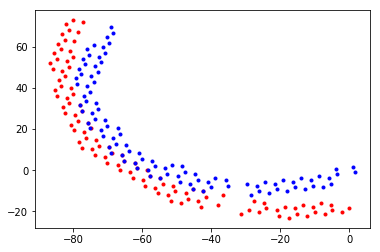

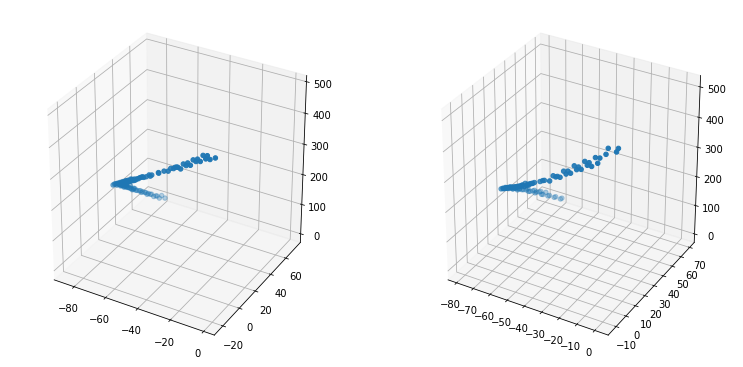

In [102]:
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(Random_uvw_values[:, 7], Random_uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(Random_uvw_values[:, 5], Random_uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_uvw_values[:,5],Random_uvw_values[:,6],Random_uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])